Initialize the environment

In [19]:
from TamGen_Demo import TamGenDemo, prepare_pdb_data, prepare_pdb_data_center
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"


In [ ]:

worker = TamGenDemo(
    data="./TamGen_Demo_Data",
    ckpt="checkpoints/crossdock_pdb_A10/checkpoint_best.pt",
    use_conditional=True,
)

Set the PDB you want to generate cmpds

In [86]:
pdb_id = "7te0" # "5dzk, 7d1m" "7te0"
prepare_pdb_data(pdb_id,)


In [24]:
prepare_pdb_data("7TE0", DemoDataFolder="TamGen_Demo_Data", thr=10)  # -> gen_7te0_t10
prepare_pdb_data("7TE0", DemoDataFolder="TamGen_Demo_Data", thr=15)  # -> gen_7te0_t15

# explicit center (example coords; replace with yours)
prepare_pdb_data_center("7TE0", center_xyz=(12.3, 34.5, 6.7),
                        DemoDataFolder="TamGen_Demo_Data", thr=12)

Visualize the molecules

In [11]:
worker.reload_data(subset="gen_" + pdb_id.lower())

hyps, ref = worker.sample(
    m_sample=5000, 
    maxseed=30,
)

In [20]:
from rdkit import Chem 
from rdkit.Chem import  DataStructs # Draw, AllChem,
from rdkit.Chem import MACCSkeys

In [21]:
import torch

In [22]:
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True 

In [23]:
print("CUDA:", torch.version.cuda, "| Torch:", torch.__version__)
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")
print("TF32 matmul allowed:", torch.backends.cuda.matmul.allow_tf32)
print("TF32 cuDNN allowed:", torch.backends.cudnn.allow_tf32)

CUDA: 12.1 | Torch: 2.3.0
Device: NVIDIA GeForce RTX 3080 Laptop GPU
TF32 matmul allowed: True
TF32 cuDNN allowed: True


In [25]:
try:
    torch.set_float32_matmul_precision('medium')
    print("matmul precision:", torch.get_float32_matmul_precision())
except Exception:
    pass


matmul precision: medium


### Conditional(VAE) 

In [26]:
### Contextual Conditional VAE
worker_condition = TamGenDemo(
    data="./TamGen_Demo_Data",
    ckpt="checkpoints/crossdock_pdb_A10/checkpoint_best.pt",
    use_conditional=True,
    
)
worker_condition.args.sampling_topp = 0.95   
worker_condition.args.sampling_temp = 1.0
worker_condition.args.sampling_repetition_penalty = 1.2
worker_condition.args.sampling_max_len = 100
worker_condition.args.sampling_min_len = 10
worker_condition.args.fp16=True

Namespace(no_progress_bar=False, log_interval=1000, log_format=None, tensorboard_logdir='', tbmf_wrapper=False, seed=1, cpu=False, fp16=False, memory_efficient_fp16=False, fp16_init_scale=128, fp16_scale_window=None, fp16_scale_tolerance=0.0, min_loss_scale=0.0001, threshold_loss_scale=None, user_dir=None, criterion='cross_entropy', tokenizer=None, bpe=None, optimizer='nag', lr_scheduler='fixed', task='translation_coord', num_workers=1, skip_invalid_size_inputs_valid_test=False, max_tokens=1024, max_sentences=None, required_batch_size_multiple=8, dataset_impl=None, gen_subset='gen_8fln', num_shards=1, shard_id=0, path='checkpoints/crossdock_pdb_A10/checkpoint_best.pt', remove_bpe=None, quiet=False, model_overrides='{}', results_path=None, beam=20, nbest=20, max_len_a=0, max_len_b=200, min_len=1, match_source_len=False, no_early_stop=False, unnormalized=False, no_beamable_mm=False, lenpen=1, unkpen=0, replace_unk=None, sacrebleu=False, score_reference=False, prefix_size=0, prefix_string

### No Conditional

In [27]:
worker_nocondition = TamGenDemo(
    data="./TamGen_Demo_Data",
    ckpt="checkpoints/crossdock_pdb_A10/checkpoint_best.pt",
    use_conditional=False,
)
worker_nocondition.args.sampling_topp = 0.95   
worker_nocondition.args.sampling_temp = 1.0
worker_nocondition.args.sampling_repetition_penalty = 1.2
worker_nocondition.args.sampling_max_len = 100
worker_nocondition.args.sampling_min_len = 10
worker_nocondition.args.fp16=True

Namespace(no_progress_bar=False, log_interval=1000, log_format=None, tensorboard_logdir='', tbmf_wrapper=False, seed=1, cpu=False, fp16=False, memory_efficient_fp16=False, fp16_init_scale=128, fp16_scale_window=None, fp16_scale_tolerance=0.0, min_loss_scale=0.0001, threshold_loss_scale=None, user_dir=None, criterion='cross_entropy', tokenizer=None, bpe=None, optimizer='nag', lr_scheduler='fixed', task='translation_coord', num_workers=1, skip_invalid_size_inputs_valid_test=False, max_tokens=1024, max_sentences=None, required_batch_size_multiple=8, dataset_impl=None, gen_subset='gen_8fln', num_shards=1, shard_id=0, path='checkpoints/crossdock_pdb_A10/checkpoint_best.pt', remove_bpe=None, quiet=False, model_overrides='{}', results_path=None, beam=20, nbest=20, max_len_a=0, max_len_b=200, min_len=1, match_source_len=False, no_early_stop=False, unnormalized=False, no_beamable_mm=False, lenpen=1, unkpen=0, replace_unk=None, sacrebleu=False, score_reference=False, prefix_size=0, prefix_string

In [21]:
wn = worker_nocondition    # and also do the same for a “baseline” worker_condition if you insist
wn.args.sampling = False       # USE BEAM, like paper
wn.args.beam = 20
wn.args.nbest = 20

w = worker_condition
w.args.sampling = False
w.args.beam = 20
w.args.nbest = 20
w.args.sample_beta = 0.1

In [22]:
pdb_id = "7te0" # "5dzk, 7d1m" "7te0"
# prepare_pdb_data(pdb_id,)

In [23]:
worker_nocondition.reload_data(subset="gen_" + pdb_id.lower())
worker_condition.reload_data(subset="gen_" + pdb_id.lower())

In [24]:
import pandas as pd

In [25]:
mols_ncond, ref_ncond = worker_nocondition.sample(
    m_sample=100, 
    # maxseed=1000,
    use_cuda=True
)

In [27]:
mols_cond, ref_cond = worker_condition.sample(
    m_sample=100, 
    maxseed=100,
    use_cuda=True
)

In [28]:
df_ncond = pd.DataFrame(list(mols_ncond.items()), columns=["SMILES_nocond", "Index"])
df_ncond.to_csv(f"mols_ncond_gened_4_{pdb_id}.csv")
df_cond = pd.DataFrame(list(mols_cond.items()), columns=["SMILES_cond", "Index"])
df_cond.to_csv(f"mols_cond_gened_4_{pdb_id}.csv")

In [29]:
pdb_id = "7d1m" # "5dzk, 7d1m" "7te0"

In [30]:
worker_nocondition.reload_data(subset="gen_" + pdb_id.lower())
worker_condition.reload_data(subset="gen_" + pdb_id.lower())

In [31]:
mols_ncond, ref_ncond = worker_nocondition.sample(
    m_sample=100, 
    # maxseed=1000,
    use_cuda=True
)


In [32]:
mols_cond, ref_cond = worker_condition.sample(
    m_sample=100, 
    maxseed=100,
    use_cuda=True
)

In [33]:
df_ncond = pd.DataFrame(list(mols_ncond.items()), columns=["SMILES_nocond", "Index"])
df_ncond.to_csv(f"mols_ncond_gened_5_{pdb_id}.csv")
df_cond = pd.DataFrame(list(mols_cond.items()), columns=["SMILES_cond", "Index"])
df_cond.to_csv(f"mols_cond_gened_5_{pdb_id}.csv")

In [19]:
# print(len(mols_cond))
print(len(mols_ncond))

In [119]:
ref_ncond

In [120]:
ref_cond

In [4]:
import pandas as pd

In [5]:
pdb_id ="7te0"

In [6]:
df_ncond = pd.read_csv(f"mols_ncond_gened_3_{pdb_id}.csv")
df_cond = pd.read_csv(f"mols_cond_gened_3_{pdb_id}.csv")

In [7]:
gens_ncond = df_ncond["SMILES_nocond"].tolist()
gens_cond = df_cond["SMILES_cond"].tolist()

In [8]:
gens_ncond

['Cc1cc2c(cc1C)N(C[C@H](O)[C@H](O)[C@H](O)CO)c1nc(O)nc(O)c1N2',
 'CC1(C)S[C@@H]2[C@H](N=C(O)Cc3ccccc3)C(=O)N2[C@H]1C(=O)O',
 'COc1ccc(S(=O)(=O)N(Cc2cccnc2)[C@@H](C)C(O)=NO)cc1',
 'CC(C)C[C@H](N=C(O)[C@H](Cc1ccccc1)N=C(O)c1cnccn1)B(O)O',
 'COc1ccc(S(=O)(=O)N(Cc2cccnc2)[C@H](C)C(O)=NO)cc1',
 'N=c1ccn([C@H]2CC[C@@H](COP(=O)(O)O)O2)c(O)n1',
 'Cc1ncc(COP(=O)(O)O)c(CN[C@@H]2CON=C2O)c1O',
 'N=c1ccn([C@H]2CC[C@@H](COP(=O)=O)O2)c(O)n1',
 'CN(C)c1cccc2c(S(=O)(=O)O)cccc12',
 'Cc1ncc(COP(=O)(O)O)c(CN[C@@H]2CO[C@H](c3ccccc3)C2)c1O',
 'N=c1nc(O)c2c([nH]1)NC[C@H](CCc1ccc(C(=O)O)cc1)N2',
 'Cc1cc2c(cc1C)N(C[C@H](O)[C@H](O)[C@H](O)CO)c1c(O)nc(O)nc1N2',
 'Cc1ncc(COP(=O)(O)O)c(CN[C@H]2C[C@@H](C)[C@H](O)[C@@H](C)C2)c1O',
 'Cc1ncc(COP(=O)(O)O)c(CN[C@@H]2CO[C@H](c3ccccc3)[C@@H]2O)c1O',
 'N=c1nc(O)c2c([nH]1)NC[C@H](CNc1ccc(C(=O)O)cc1)N2C=O',
 'CC1(C)S[C@H]2[C@@H](OC(=O)[C@H]2N=C(O)Cc2ccccc2)[C@H]1O',
 'N=c1nc(O)c2c([nH]1)NC[C@H](CNc1ccc(C(=O)O)cc1)O2',
 'N=c1nc(O)c2c([nH]1)NC[C@H](CCc1ccc(C(=O)O)cc1)N2C=O',
 

In [68]:
gens_ncond = []
fp_ref = MACCSkeys.GenMACCSKeys(ref_ncond)

for k,v in mols_ncond.items():
    fp = MACCSkeys.GenMACCSKeys(v)
    similarity = DataStructs.FingerprintSimilarity(fp_ref, fp, metric=DataStructs.TanimotoSimilarity)
    gens_ncond.append((v,k, similarity))

# sorted_gen = sorted(gens_ncond, key=lambda e: e[-1], reverse=True)

# img=Draw.MolsToGridImage([e[0] for e in sorted_gen], molsPerRow=5, legends=["idx={}, morgan={:.2f}".format(ii, e[2]) for ii, e in enumerate(sorted_gen)])
# nimg=Draw.MolsToGridImage([e[0] for e in gens_ncond], molsPerRow=6, legends=["idx={}".format(ii+1) for ii in range(len(gens_ncond))])

# nimg

In [122]:
gens_cond = []
fp_ref = MACCSkeys.GenMACCSKeys(ref_cond)

for k,v in mols_cond.items():
    fp = MACCSkeys.GenMACCSKeys(v)
    similarity = DataStructs.FingerprintSimilarity(fp_ref, fp, metric=DataStructs.TanimotoSimilarity)
    gens_cond.append((v,k, similarity))

# sorted_gen = sorted(gens_cond, key=lambda e: e[-1], reverse=True)

# img=Draw.MolsToGridImage([e[0] for e in sorted_gen], molsPerRow=5, legends=["idx={}, morgan={:.2f}".format(ii, e[2]) for ii, e in enumerate(sorted_gen)])
img=Draw.MolsToGridImage([e[0] for e in gens_cond], molsPerRow=6, legends=["idx={}".format(ii+1) for ii in range(len(gens_cond))])

img

In [4]:
import torch
import torch_cluster

In [ ]:
import pandas as pd
import numpy as np
# df = pd.read_csv("tmp_pdb.csv")  # or "utf-8-sig" if BOMmed UTF-8
# df.to_csv("tmp_pdb.csv", index=False, encoding="utf-8")

In [6]:
print("torch", torch.__version__, "cuda", torch.version.cuda)
print("torch_cluster:", torch_cluster.__file__)

# diversity: compute Morgan FPs then 1 - average Tanimoto across the set


## RDKIT EVALUATION

In [2]:
from rdkit import Chem
from rdkit.Chem import Descriptors, QED, rdMolDescriptors, DataStructs
# SAScore: put sascorer.py on PYTHONPATH (from RDKit contrib)
import sys
from rdkit.Chem import RDConfig
import os
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))

import sascorer
import numpy as np
sascorer.readFragmentScores()


In [69]:
m = Chem.MolFromSmiles(gens_3[125][1])
m

#### Cannonical smiles

In [10]:
try:
    import sascorer  # RDKit contrib (Ertl & Schuffenhauer)
    HAS_SA = True
except Exception:
    HAS_SA = False

def canon(smi: str):
    m = Chem.MolFromSmiles(smi)
    if not m:
        return None, None
    return Chem.MolToSmiles(m, isomericSmiles=True, canonical=True), m

def lipinski_violations(m):
    mw   = Descriptors.MolWt(m)
    hbd  = rdMolDescriptors.CalcNumHBD(m)
    hba  = rdMolDescriptors.CalcNumHBA(m)
    logp = Descriptors.MolLogP(m)
    viol = int(mw>500) + int(hbd>5) + int(hba>10) + int(logp>5)
    return viol

def per_mol_metrics(m):
    row = {}
    row['qed']  = QED.qed(m)
    row['mw']   = Descriptors.MolWt(m)
    row['logp'] = Descriptors.MolLogP(m)
    row['hbd']  = rdMolDescriptors.CalcNumHBD(m)
    row['hba']  = rdMolDescriptors.CalcNumHBA(m)
    row['sa']   = (sascorer.calculateScore(m) if HAS_SA else None)
    row['lipinski_viol'] = lipinski_violations(m)
    row['lipinski_pass'] = int(row['lipinski_viol'] == 0)
    return row

def morgan_fp(m, radius=2, nbits=2048): # molecule to morgan fingerprint
    return rdMolDescriptors.GetMorganFingerprintAsBitVect(m, radius, nBits=nbits)

def evaluate_smiles(smiles_list, sample_pairs_cap=50000):
    # Canonicalize, drop invalid, collect metrics
    can, mols, fps, rows = [], [], [], []
    for smi in smiles_list:
        cs, m = canon(smi)
        if cs is None:
            continue
        can.append(cs); mols.append(m); fps.append(morgan_fp(m))
        r = per_mol_metrics(m)
        r['smiles'] = cs
        rows.append(r)
        
    n_total    = len(smiles_list)
    n_valid    = len(mols)
    uniq_count = len(set(can))
    validity   = 100.0 * n_valid / max(1, n_total)
    uniqueness = 100.0 * uniq_count / max(1, n_valid)

    # Diversity: 1 - mean Tanimoto over (sampled) distinct pairs
    diversity = None
    if len(fps) >= 2:
        # sample up to 'sample_pairs_cap' random pairs for speed
        idx = np.arange(len(fps))
        pairs = []
        # exact pairs if small; otherwise sample
        if (len(fps)*(len(fps)-1))//2 <= sample_pairs_cap:
            for i in range(len(fps)):
                for j in range(i+1, len(fps)):
                    pairs.append((i,j))
        else:
            rng = np.random.default_rng(0)
            for _ in range(sample_pairs_cap):
                i, j = rng.integers(0, len(fps), 2)
                if i==j: 
                    j = (j+1) % len(fps)
                if i>j: i,j = j,i
                pairs.append((i,j))
            # de-dup sampled pairs
            pairs = list(set(pairs))

            
        sims = [DataStructs.TanimotoSimilarity(fps[i], fps[j]) for i,j in pairs]
        diversity = float(1.0 - (sum(sims)/len(sims)))

    df = pd.DataFrame(rows)
    summary = {
        'n_total': n_total,
        'n_valid': n_valid,
        'molecule_validity_%': round(validity, 2),
        'n_unique': uniq_count,
        'uniqueness_%': round(uniqueness, 2),
        'qed_mean': round(float(df['qed'].mean()) if not df.empty else float('nan'), 3),
        'sa_mean':  round(float(df['sa'].mean())  if HAS_SA and not df.empty else float('nan'), 3),
        'logp_mean': round(float(df['logp'].mean()) if not df.empty else float('nan'), 3),
        'lipinski_pass_%': round(100.0*float(df['lipinski_pass'].mean()) if not df.empty else 0.0, 2),
        'diversity_(1-meanTanimoto)': (round(diversity, 3) if diversity is not None else None),
    }
    return df, summary

### Save Evaluated Metrics Results

In [70]:
smiles_cond = [row[1] for row in gens_cond]   # adjust if your structure differs
df_cond, summary_cond = evaluate_smiles(smiles_cond)

# Save results and print summary
df_cond.to_csv("results/metrics_7te0_cond_3.csv", index=False)
print(summary_cond)

In [71]:
smiles_ncond = [row[1] for row in gens_ncond]   # adjust if your structure differs
df_ncond, summary_ncond = evaluate_smiles(smiles_ncond)

# Save results and print summary
df_ncond.to_csv("results/metrics_7te0_ncond_3.csv", index=False)
print(summary_ncond)

In [13]:
df_cond = pd.read_csv("results/metrics_7te0_cond_3.csv")
df_ncond = pd.read_csv("results/metrics_7te0_ncond_3.csv")


In [14]:
import matplotlib.pyplot as plt

def hist(ax, data, title, bins=30):
    ax.hist(data)
    ax.set_title(title)

def compare_hist(metric, label, bins=30):
    plt.hist(df_ncond[metric], bins=bins, alpha=0.6, label='No VAE')
    plt.hist(df_cond[metric],  bins=bins, alpha=0.6, label='With VAE')
    plt.title(label)
    plt.legend()

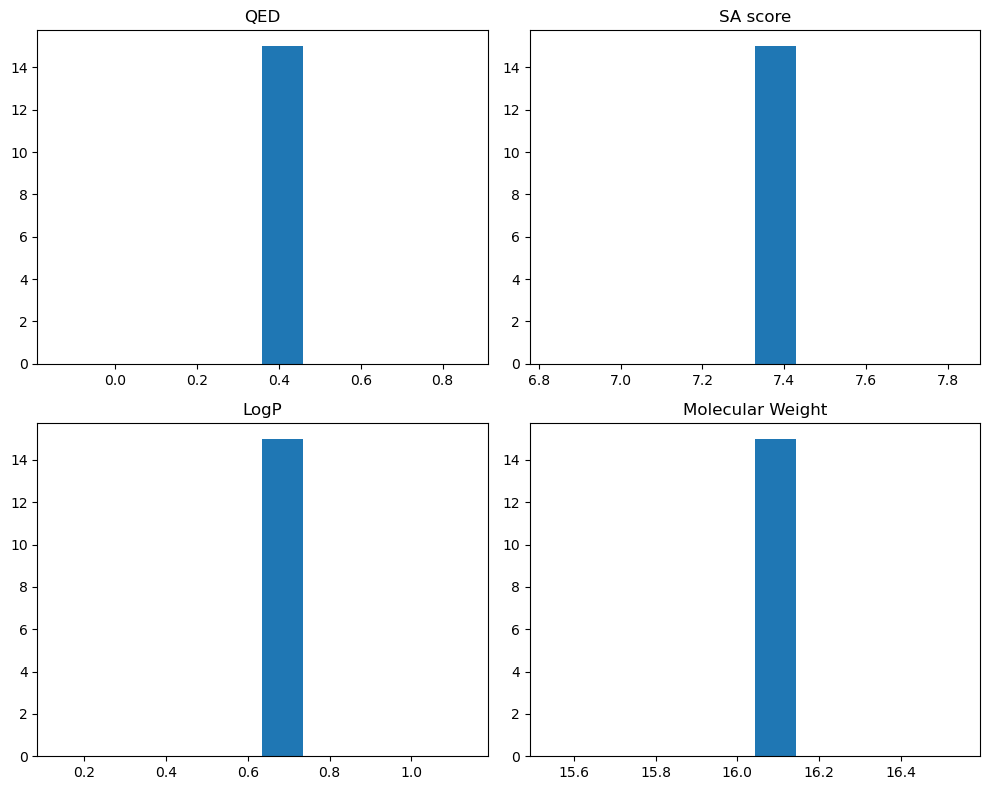

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(10,8))
if not df_cond.empty:
    hist(axs[0,0], df_cond['qed'],           'QED')
    hist(axs[0,1], df_cond['sa'].dropna(),   'SA score')
    hist(axs[1,0], df_cond['logp'],          'LogP')
    hist(axs[1,1], df_cond['mw'],            'Molecular Weight')
plt.tight_layout()
plt.show()

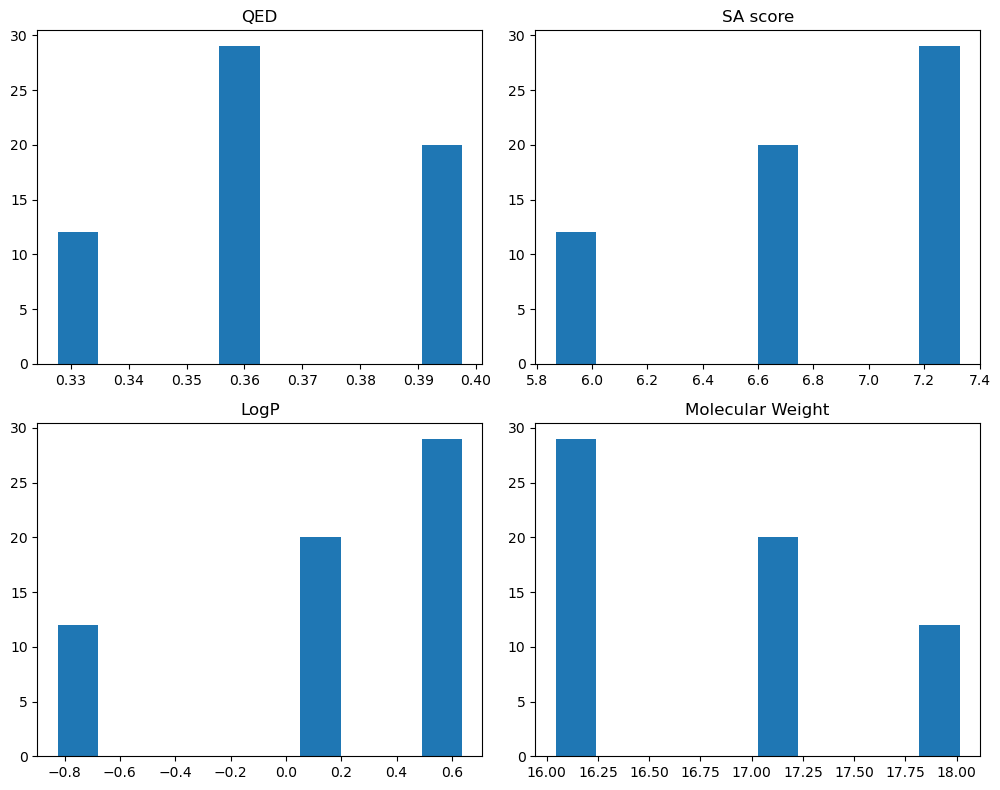

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(10,8))
if not df_ncond.empty:
    hist(axs[0,0], df_ncond['qed'],           'QED')
    hist(axs[0,1], df_ncond['sa'].dropna(),   'SA score')
    hist(axs[1,0], df_ncond['logp'],          'LogP')
    hist(axs[1,1], df_ncond['mw'],            'Molecular Weight')
plt.tight_layout()
plt.show()

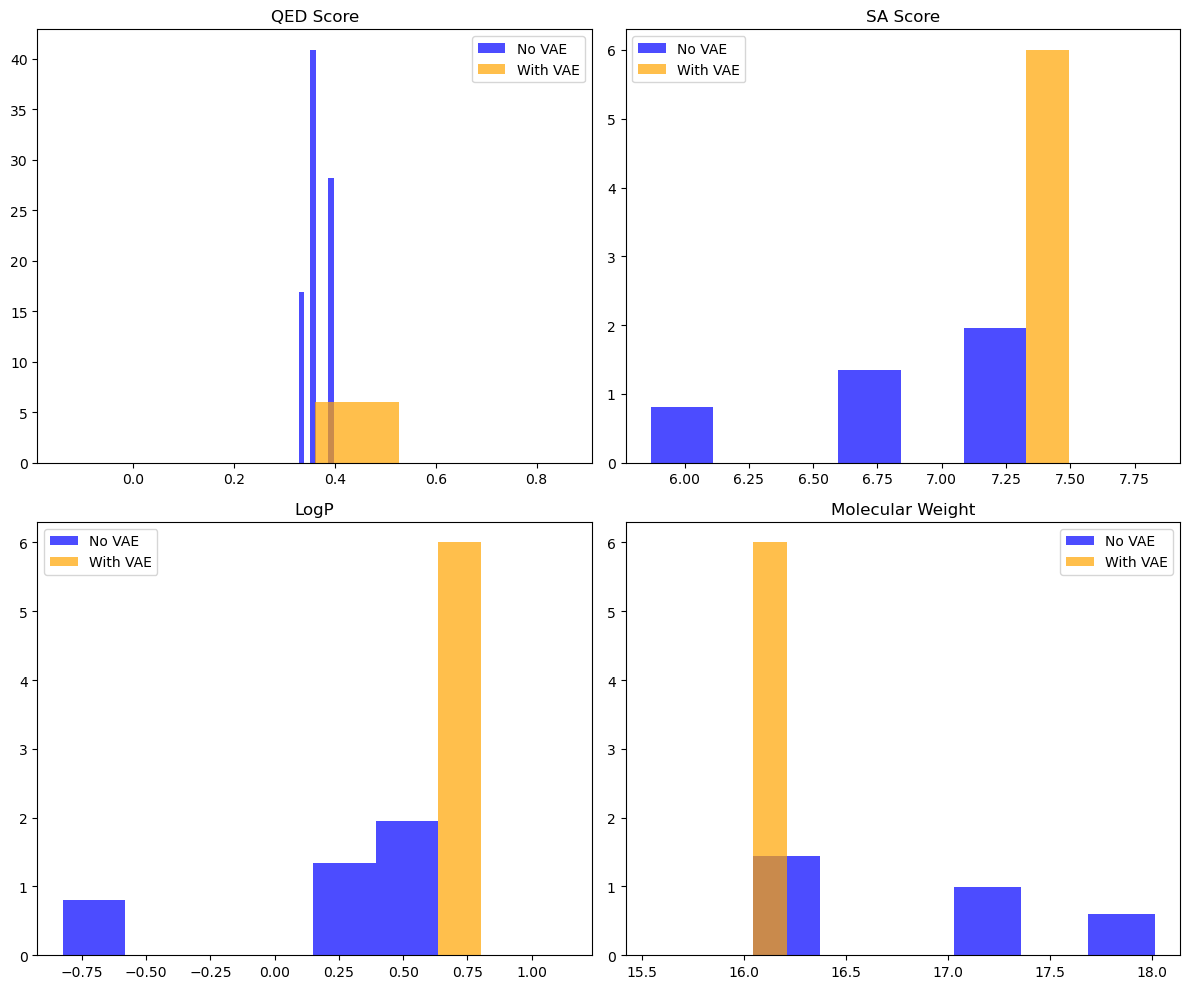

In [17]:
colors = {'No VAE': 'blue', 'With VAE': 'orange'}
alpha = 0.7

fig, axes = plt.subplots(2, 2, figsize=(12,10))

pairs = [
    ('qed',  'QED Score'),
    ('sa',   'SA Score'),
    ('logp', 'LogP'),
    ('mw',   'Molecular Weight'),
]

for ax, (col, title) in zip(axes.flatten(), pairs):
    data = []
    if not df_ncond.empty:
        ax.hist(df_ncond[col], bins=6, color=colors['No VAE'],
                alpha=alpha, density=True, label='No VAE')
    if not df_cond.empty:
        ax.hist(df_cond[col], bins=6, color=colors['With VAE'],
                alpha=alpha, density=True, label='With VAE')
    ax.set_title(title)
    ax.legend()
plt.tight_layout()
plt.show()

In [131]:
print(df_cond.describe())
print(df_ncond.describe())

In [80]:
import matplotlib.pyplot as plt

# Pull from your summaries
div_n = summary_ncond['diversity_(1-meanTanimoto)']
div_c = summary_cond['diversity_(1-meanTanimoto)']
ro5_n = summary_ncond['lipinski_pass_%'] / 100.0   # normalize to 0–1
ro5_c = summary_cond['lipinski_pass_%'] / 100.0

metrics = ['Diversity (1−Tanimoto)', 'RO5 pass rate']
no_vae = [div_n, ro5_n]
vae    = [div_c, ro5_c]

x = range(len(metrics))
w = 0.35

fig, ax = plt.subplots(figsize=(7,4))
ax.bar([i - w/2 for i in x], no_vae, width=w, label='No VAE')
ax.bar([i + w/2 for i in x], vae,    width=w, label='With VAE')

ax.set_ylim(0, 1.0)
ax.set_xticks(list(x))
ax.set_xticklabels(metrics, rotation=0)
ax.set_ylabel('Normalized value (0–1)')
ax.set_title('Diversity & RO5 (normalized)')
ax.legend()

# value labels
for i, v in enumerate(no_vae):
    ax.text(i - w/2, v + 0.02, f"{v:.2f}", ha='center', va='bottom', fontsize=9)
for i, v in enumerate(vae):
    ax.text(i + w/2, v + 0.02, f"{v:.2f}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


In [81]:
from rdkit import Chem, DataStructs
from rdkit.Chem import rdMolDescriptors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def set_diversity(smiles, sample_pairs=50000, seed=0):
    """Diversity = 1 - mean Tanimoto over Morgan(2,2048)."""
    mols = [Chem.MolFromSmiles(s) for s in smiles]
    mols = [m for m in mols if m is not None]
    if len(mols) < 2: return np.nan
    fps = [rdMolDescriptors.GetMorganFingerprintAsBitVect(m, 2, nBits=2048) for m in mols]
    n = len(fps)
    total_pairs = n*(n-1)//2
    rng = np.random.default_rng(seed)
    if total_pairs <= sample_pairs:
        pairs = [(i,j) for i in range(n) for j in range(i+1, n)]
    else:
        pairs = set()
        while len(pairs) < sample_pairs:
            i = rng.integers(0,n); j = rng.integers(0,n)
            if i==j: continue
            if i>j: i,j=j,i
            pairs.add((i,j))
        pairs = list(pairs)
    sims = [DataStructs.TanimotoSimilarity(fps[i], fps[j]) for i,j in pairs]
    return float(1.0 - (sum(sims)/len(sims)))

def summarize_set(df, original_count=None):
    """
    df columns expected: smiles, qed, sa, logp, lipinski_pass (1/0)
    Returns a dict with set-level metrics.
    """
    # validity & uniqueness (use original_count if you want to reflect invalid drops)
    n_total = int(original_count if original_count is not None else len(df))
    n_valid = int(len(df))
    validity_pct = 100.0 * (n_valid / max(1, n_total))
    uniqueness_pct = 100.0 * (len(set(df.smiles)) / max(1, n_valid))

    # diversity from SMILES
    div = set_diversity(list(df.smiles))

    d = dict(
        n_total=n_total, n_valid=n_valid,
        validity_pct=validity_pct,
        uniqueness_pct=uniqueness_pct,
        qed_mean=float(df.qed.mean()) if len(df) else np.nan,
        sa_mean=float(df.sa.mean()) if ("sa" in df and len(df)) else np.nan,
        logp_mean=float(df.logp.mean()) if len(df) else np.nan,
        lipinski_pass_pct=100.0*float(df.lipinski_pass.mean()) if ("lipinski_pass" in df and len(df)) else np.nan,
        diversity=div
    )
    return d

def normalize_for_heatmap(summaries, docking_key=None):
    """
    Convert dict of name->metrics into a (metrics x conditions) matrix in [0,1], “higher=better”.
    If docking_key is provided (e.g., 'vina_mean'), uses abs(value) before min-max.
    For metrics where lower is better (e.g., SA mean), we invert after min-max.
    """
    # Which metrics to include (paper core metrics)
    metric_info = [
        ("qed_mean",          True,  "max"),    # higher better
        ("lipinski_pass_pct", True,  "max"),    # higher better
        ("sa_mean",           False, "min"),    # lower better => invert
        ("logp_mean",         None,  "mid"),    # show raw in table; heatmap uses % in 0-5 below
        ("diversity",         True,  "max"),    # higher better
    ]
    # If you computed % in-range for LogP, include it instead of raw mean:
    # e.g., summaries[name]["logp_in_range_pct"] = 100 * mean(0 <= logp <= 5)
    has_logp_pct = all(("logp_in_range_pct" in v) for v in summaries.values())
    if has_logp_pct:
        metric_info.append(("logp_in_range_pct", True, "max"))

    # Optional docking (mean, best, or top5)
    if docking_key is not None and all((docking_key in v) for v in summaries.values()):
        metric_info.append((docking_key, True, "dock"))  # we'll abs() then min-max

    # Build raw matrix
    names = list(summaries.keys())
    rows = []
    meta = []  # (metric_name, mode)
    for key, higher_is_better, mode in metric_info:
        vals = [summaries[n].get(key, np.nan) for n in names]
        rows.append(vals)
        meta.append((key, higher_is_better, mode))
    M = np.array(rows, dtype=float)

    # Prepare a normalized version
    M_norm = np.zeros_like(M)
    for i,(key,hib,mode) in enumerate(meta):
        col = M[i,:].copy()
        if mode=="dock":
            col = np.abs(col)               # paper: absolute values used in normalization
        if mode=="min":
            # lower better -> normal min-max then invert
            mn, mx = np.nanmin(col), np.nanmax(col)
            v = (col - mn) / (mx - mn + 1e-12)
            M_norm[i,:] = 1.0 - v
        elif mode=="max":
            mn, mx = np.nanmin(col), np.nanmax(col)
            M_norm[i,:] = (col - mn) / (mx - mn + 1e-12)
        elif mode=="mid":
            # Leave raw out of heatmap; if present, set NaNs to avoid plotting
            M_norm[i,:] = np.nan
        else:
            M_norm[i,:] = np.nan

    # Scale percentages to 0–1 if any (e.g., lipinski_pass_pct)
    for i,(key,hib,mode) in enumerate(meta):
        if key.endswith("_pct") and mode in ("min","max","dock"):
            M_norm[i,:] = M_norm[i,:]  # already min-max across conditions

    return names, meta, M, M_norm

def plot_heatmap(names, meta, M_norm, title="TamGen metrics (normalized, higher=better)"):
    # Filter out rows that are NaN-only (e.g., raw logp_mean if not normalized)
    keep = ~np.all(np.isnan(M_norm), axis=1)
    M2 = M_norm[keep,:]
    labels = [m[0] for i,m in enumerate(meta) if keep[i]]

    fig, ax = plt.subplots(figsize=(6, 0.6*len(labels)+2))
    im = ax.imshow(M2, aspect='auto')  # default colormap
    ax.set_yticks(np.arange(len(labels)))
    ax.set_yticklabels(labels)
    ax.set_xticks(np.arange(len(names)))
    ax.set_xticklabels(names)
    # annotate
    for i in range(M2.shape[0]):
        for j in range(M2.shape[1]):
            if np.isfinite(M2[i,j]):
                ax.text(j, i, f"{M2[i,j]:.2f}", ha="center", va="center", fontsize=9)
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("Normalized (0–1)")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()


def norm_clip(v, lo, hi, invert=False):
    v = np.clip(v, lo, hi)
    x = (v - lo) / (hi - lo + 1e-12)
    return 1.0 - x if invert else x

def prepare_heatmap_matrix(summaries, include_docking_key=None):
    """
    summaries: dict like {"No VAE": {...}, "With VAE": {...}}
      expected keys per summary:
      - "qed_mean" in [0,1]
      - "sa_mean"  ~[1,10]   (lower better)
      - "lipinski_pass_%"
      - "diversity" in [0,1]
      - optional "logp_in_range_pct" (preferred) OR "logp_mean"
      - optional docking key like "vina_mean" (negative, better if more negative)
    returns names, labels, H (normalized 0..1)
    """
    names = list(summaries.keys())

    # Build rows as (label, normalized_values_array)
    rows = []

    # QED (0..1)
    rows.append( ("QED (mean)", np.array([summaries[n].get("qed_mean", np.nan) for n in names])) )

    # SA (1..10), lower is better -> invert
    sa_vals = np.array([summaries[n].get("sa_mean", np.nan) for n in names])
    rows.append( ("SA (mean)", norm_clip(sa_vals, 1.0, 10.0, invert=True)) )

    # Lipinski pass % (0..100)
    lip_vals = np.array([summaries[n].get("lipinski_pass_pct", np.nan) for n in names])
    rows.append( ("RO5 pass (%)", lip_vals/100.0) )

    # Diversity (0..1)
    div_vals = np.array([summaries[n].get("diversity", np.nan) for n in names])
    rows.append( ("Diversity (1 - Tanimoto)", div_vals) )

    # LogP quality: prefer percent in [0,5], else derive a centered score from mean
    if all(("logp_in_range_pct" in summaries[n] for n in names)):
        logp_pct = np.array([summaries[n]["logp_in_range_pct"] for n in names])
        rows.append( ("LogP in [0,5] (%)", logp_pct/100.0) )
    elif all(("logp_mean" in summaries[n] for n in names)):
        # center at 2.5 (middle of 0..5) and penalize distance; clip beyond ±2.5
        lm = np.array([summaries[n]["logp_mean"] for n in names])
        rows.append( ("LogP (centered quality)", 1.0 - np.minimum(np.abs(lm-2.5)/2.5, 1.0)) )

    # Docking (optional): normalize by absolute value in a window, e.g., [-12, -2]
    if include_docking_key and all((include_docking_key in summaries[n] for n in names)):
        d = np.array([summaries[n][include_docking_key] for n in names], dtype=float)
        # map [-12..-2] -> [1..0] by abs and then min-max; clamp outside range
        rows.append( (f"Docking ({include_docking_key})", norm_clip(np.abs(d), 2.0, 12.0, invert=False)) )

    labels = [r[0] for r in rows]
    H = np.vstack([ (r[1] if r[0]!="QED (mean)" else r[1]) for r in rows ])
    return names, labels, H

def plot_heatmap_fixed(names, labels, H, title="Evaluation metrics (normalized 0–1, higher=better)"):
    fig, ax = plt.subplots(figsize=(6, 0.6*len(labels)+2))
    im = ax.imshow(H, aspect='auto', vmin=0, vmax=1)
    ax.set_yticks(np.arange(len(labels))); ax.set_yticklabels(labels)
    ax.set_xticks(np.arange(len(names)));  ax.set_xticklabels(names)
    for i in range(H.shape[0]):
        for j in range(H.shape[1]):
            if np.isfinite(H[i,j]):
                ax.text(j, i, f"{H[i,j]:.2f}", ha='center', va='center', fontsize=9)
    cbar = plt.colorbar(im); cbar.set_label("Normalized (0–1)")
    ax.set_title(title)
    plt.tight_layout(); plt.show()


In [82]:

summary_n = summarize_set(df_ncond)
summary_c = summarize_set(df_cond)

# Optional: add "% LogP in [0,5]"
summary_n["logp_in_range_pct"] = 100.0 * float(((df_ncond["logp"]>=0) & (df_ncond["logp"]<=5)).mean()) if len(df_ncond) else np.nan
summary_c["logp_in_range_pct"] = 100.0 * float(((df_cond["logp"]>=0) & (df_cond["logp"]<=5)).mean()) if len(df_cond) else np.nan

summaries = {
    "No VAE": summary_n,
    "With VAE": summary_c
}


names, labels, H = prepare_heatmap_matrix(summaries, include_docking_key=None)  # add later
plot_heatmap_fixed(names, labels, H)

In [83]:
names, labels, H = prepare_heatmap_matrix(summaries)  #, docking_key=None
plot_heatmap(names, labels, H) # Raw table (means in native units) 
raw_rows = [] 
for name, S in summaries.items(): 
    raw_rows.append({ "condition": name, 
                     "QED_mean": S.get("qed_mean"), 
                     "SA_mean": S.get("sa_mean"), 
                     "LogP_mean": S.get("logp_mean"), 
                     "RO5_pass_%": S.get("lipinski_pass_%"), 
                     "Diversity(1−Tanimoto)": S.get("diversity_(1-meanTanimoto)")
                       }) 
df_raw = pd.DataFrame(raw_rows) 
df_raw 

In [84]:
import pandas as pd
import numpy as np

# Ensure consistent order and numeric types
df = (df_raw
      .set_index("condition")
      .loc[["No VAE", "With VAE"]]
      .apply(pd.to_numeric, errors="coerce"))

# Add a delta row (With VAE − No VAE)
delta = (df.loc["With VAE"] - df.loc["No VAE"]).to_frame().T
delta.index = ["Δ (With − No)"]
df_show = pd.concat([df, delta])

# Nice formatting + gradients (blue for “higher is better”, red for SA which is “lower is better”)
sty = (df_show.style
       .format({
           "QED_mean": "{:.3f}",
           "SA_mean": "{:.3f}",
           "LogP_mean": "{:.3f}",
           "RO5_pass_%": "{:.1f}%",
           "Diversity(1−Tanimoto)": "{:.3f}",
       })
       # highlight "higher is better" metrics
       .background_gradient(axis=0, cmap="Blues",
                            subset=pd.IndexSlice[["No VAE","With VAE"],
                                ["QED_mean","LogP_mean","RO5_pass_%","Diversity(1−Tanimoto)"]])
       # highlight SA separately (lower is better) by inverting values
       .background_gradient(axis=0, cmap="Reds",
                            subset=pd.IndexSlice[["No VAE","With VAE"],["SA_mean"]])
       .set_properties(subset=pd.IndexSlice[["Δ (With − No)"], :],
                       **{"font-weight":"bold"})
      )
sty


In [85]:
criteria = [
    ("QED (0–1, higher better)",        "≈0.5–0.7 common for drugs; ≥0.5 is solid"),
    ("SA (1–10, lower better)",         "≤6 preferred; >6 gets harder"),
    ("LogP (oral window)",              "0–5 (many aim ≈1–3)"),
    ("Lipinski RO5 pass (%)",           "High is good; often ≥80–90%"),
    ("Diversity (1−Tanimoto, 0–1)",     "Higher = more structural spread")
]

df_criteria = pd.DataFrame(criteria, columns=["Metric / Scale", "Typical criterion"])
df_criteria

In [157]:
import tempfile, subprocess, os
from rdkit.Chem import AllChem

def smiles_to_minimized_sdf(smiles, sdf_path):
    m = Chem.MolFromSmiles(smiles)
    if not m: return False
    m = Chem.AddHs(m)
    if AllChem.EmbedMolecule(m, AllChem.ETKDGv3()) != 0: return False
    AllChem.MMFFOptimizeMolecule(m, maxIters=200)
    w = Chem.SDWriter(sdf_path); w.write(m); w.close()
    return True

def sdf_to_pdbqt(sdf_path, pdbqt_path):
    # Requires meeko: pip install meeko
    r = subprocess.run(["mk_prepare_ligand.py", "-i", sdf_path, "-o", pdbqt_path],
                       capture_output=True, text=True)
    return r.returncode == 0

def vina_score(receptor_pdbqt, ligand_pdbqt, center, size, exhaustiveness=16, num_modes=9):
    cx,cy,cz = center; sx,sy,sz = size
    out_pdbqt = tempfile.mkstemp(suffix=".pdbqt")[1]
    out_log   = tempfile.mkstemp(suffix=".log")[1]
    cmd = [
        "vina", "--receptor", receptor_pdbqt, "--ligand", ligand_pdbqt,
        "--center_x", str(cx), "--center_y", str(cy), "--center_z", str(cz),
        "--size_x", str(sx), "--size_y", str(sy), "--size_z", str(sz),
        "--exhaustiveness", str(exhaustiveness), "--num_modes", str(num_modes),
        "--out", out_pdbqt, "--log", out_log
    ]
    subprocess.run(cmd, capture_output=True, text=True)
    best = None
    if os.path.exists(out_log):
        with open(out_log) as f:
            for line in f:
                if "REMARK VINA RESULT:" in line:
                    try:
                        best = float(line.split()[3])  # kcal/mol (negative = better)
                        break
                    except: pass
    return best

def batch_dock(smiles_list, receptor_pdbqt, center, size, max_n=100):
    scores=[]
    for smi in smiles_list[:max_n]:
        sdf = tempfile.mkstemp(suffix=".sdf")[1]
        pdbqt = tempfile.mkstemp(suffix=".pdbqt")[1]
        if not smiles_to_minimized_sdf(smi, sdf): scores.append(None); continue
        if not sdf_to_pdbqt(sdf, pdbqt):          scores.append(None); continue
        s = vina_score(receptor_pdbqt, pdbqt, center, size)
        scores.append(s)
    return scores


In [174]:
RECEPTOR = "pocket_7te0.pdbqt"     # your prepared receptor
CENTER   = (12.3, 34.5, 6.7)       # pocket center
SIZE     = (24, 24, 24)            # Å box size

dock_n = batch_dock(list(df_ncond["smiles"]), RECEPTOR, CENTER, SIZE, max_n=100)
dock_c = batch_dock(list(df_cond["smiles"]),  RECEPTOR, CENTER, SIZE, max_n=100)

df_ncond["vina_kcal_mol"] = dock_n
df_cond["vina_kcal_mol"]  = dock_c

# Add docking summaries (choose any/all of these)
summary_n["vina_mean"]   = float(pd.Series(dock_n).dropna().mean()) if len(dock_n) else np.nan
summary_c["vina_mean"]   = float(pd.Series(dock_c).dropna().mean()) if len(dock_c) else np.nan
summary_n["vina_best"]   = float(pd.Series(dock_n).dropna().min())  if len(dock_n) else np.nan
summary_c["vina_best"]   = float(pd.Series(dock_c).dropna().min())  if len(dock_c) else np.nan
summary_n["vina_top5"]   = float(pd.Series(sorted([d for d in dock_n if d is not None])[:5]).mean()) if pd.Series(dock_n).notna().sum()>=5 else np.nan
summary_c["vina_top5"]   = float(pd.Series(sorted([d for d in dock_c if d is not None])[:5]).mean()) if pd.Series(dock_c).notna().sum()>=5 else np.nan

# Re-normalize & plot heatmap including docking (use 'vina_mean' or 'vina_top5' as the docking_key)
summaries = {"No VAE": summary_n, "With VAE": summary_c}
names, meta, M_raw, M_norm = normalize_for_heatmap(summaries, docking_key="vina_mean")
plot_heatmap(names, meta, M_norm, title="TamGen paper metrics (+ docking, normalized)")
